## Setup

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install ONE-api
!pip install brainbox
!pip install ibllib

In [4]:
from one.api import ONE
from one.api import OneAlyx
from one.api import One

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import brainbox as bb
from brainbox.io.one import load_channel_locations

from ibllib.atlas import AllenAtlas
from ibllib.atlas.regions import BrainRegions
import logging
import spikeglx
import csv

import time
import math

from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.10/dist-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [5]:
import sys

sys.path.insert(1, 'gdrive/MyDrive')

import rid_rihaczek

In [6]:
ONE.setup(silent=True)
one = ONE(password = "international")

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/tmpk7g766ln/cache.zip Bytes: 4118421


100%|██████████| 3.9276323318481445/3.9276323318481445 [00:00<00:00,  9.80it/s]


## Load Channel IDs

In [7]:
eid = "e45481fa-be22-4365-972c-e7404ed8ab5a"

cc = load_channel_locations(eid, probe=None, one=None, aligned=False, brain_atlas=None)

ca1_channel_id = []
ot_channel_id = []

ca1_probe = ''
ot_probe = ''

for key in cc.keys():
  for i , acronym in enumerate(cc[key]['acronym']): # check exactly if the first and last index are channel indexes
    if acronym == 'CA1' :
      ca1_channel_id.append(i)

      if (ca1_probe != key):
        ca1_probe += key

    elif acronym == 'OT' :
      ot_channel_id.append(i)

      if (ot_probe != key):
        ot_probe += key

Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:01<00:00, 16.23it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:00<00:00,  4.18it/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe00/pykilosort/channels.rawInd.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 19.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.9kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe00/pykilosort/channels.mlapdv.npy: 100%|██████████| 4.74k/4.74k [00:00<00:00, 32.4kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe00/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/alf/probe01/pykilosort/channel

In [8]:
len(ot_channel_id), len(ca1_channel_id)

(10, 54)

In [9]:
ca1_probe, ot_probe

('probe01', 'probe00')

## Load Eid Data

In [10]:
dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{ca1_probe}', filename='*.lf.*')
data_files, _ = one.load_datasets(eid, dsets, download_only=True)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr_ca1 = spikeglx.Reader(bin_file)

dsets = one.list_datasets(eid, collection=f'raw_ephys_data/{ot_probe}', filename='*.lf.*')
data_files, _ = one.load_datasets(eid, dsets, download_only=True)
bin_file = next(df for df in data_files if df.suffix == '.cbin')

# Use spikeglx reader to read in the whole raw data
sr_ot = spikeglx.Reader(bin_file)

trialsTable = one.load_dataset(eid, 'alf/_ibl_trials.table.pqt')

responseTimes = trialsTable['response_times']
goCueTimes = trialsTable['goCue_times']
feedbackTimes = trialsTable['feedback_times']

samplingPeriod = 1/sr_ca1.fs
SamplingFrequency = sr_ca1.fs

/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/raw_ephys_data/probe01/_spikeglx_ephysData_g0_t0.imec1.lf.cbin: 100%|██████████| 3.97G/3.97G [00:28<00:00, 137MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/raw_ephys_data/probe01/_spikeglx_ephysData_g0_t0.imec1.lf.ch: 100%|██████████| 194k/194k [00:00<00:00, 925kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/raw_ephys_data/probe01/_spikeglx_ephysData_g0_t0.imec1.lf.meta: 100%|██████████| 14.0k/14.0k [00:00<00:00, 69.2kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.cbin: 100%|██████████| 4.14G/4.14G [00:27<00:00, 149MB/s] 
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS086/2022-03-15/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.ch: 1

In [11]:
sr_ca1.fs, sr_ot.fs

(2499.9907563025213, 2500.0)

## Clean Trial Table

It is safe to assume that NaN contrasts can be replaced with zero. Nogo trials are where both contrasts are zero. Also, when when side's contrast is greater than zero the other side is surely zero.

In [12]:
trialsTable.contrastRight.fillna(0, inplace = True)
trialsTable.contrastLeft.fillna(0, inplace = True)
trialsTable

,goCue_times,contrastLeft,feedback_times,intervals_0,intervals_1,firstMovement_times,probabilityLeft,stimOn_times,choice,rewardVolume,response_times,feedbackType,contrastRight
trial_#,,,,,,,,,,,,,
0,253.702685,1.00,259.815472,227.752901,261.364789,259.554094,0.5,253.811408,1,1.5,259.815365,1,0.0000
1,263.162007,0.00,291.382888,262.132799,293.931156,291.036094,0.5,263.160974,1,0.0,291.381819,-1,0.1250
2,295.144852,0.25,305.327610,294.630864,306.893633,304.884094,0.5,295.143852,1,1.5,305.327510,1,0.0000
3,308.265481,0.00,314.622546,307.593541,316.164571,311.621094,0.5,308.264547,-1,1.5,314.622446,1,1.0000
4,319.244767,0.00,320.144753,316.857680,322.697882,319.357094,0.5,319.243934,-1,0.0,320.143837,-1,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,4931.920652,1.00,4932.400043,4931.348837,4933.954967,4932.049094,0.2,4931.919619,1,1.5,4932.399949,1,0.0000
521,4935.126633,0.00,4947.894593,4934.662674,4950.455023,4947.517094,0.2,4935.125533,1,0.0,4947.893682,-1,0.1250
522,4951.676222,0.00,4966.683816,4951.187632,4969.236415,4963.605094,0.2,4951.675322,1,0.0,4966.682873,-1,0.2500


In [13]:
n_Trials = trialsTable.shape[0]

responseTime = trialsTable['response_times'].to_numpy()
contrastLeft = trialsTable['contrastLeft'].to_numpy()
contrastRight = trialsTable['contrastRight'].to_numpy()
response = trialsTable['choice'].to_numpy()

correctAnswers = np.ones(n_Trials)

for i in range(n_Trials):
    if (contrastRight[i] > contrastLeft[i]):
        correctAnswers[i] = -1
    elif (contrastRight[i] == contrastLeft[i]):
        correctAnswers[i] = 0

leftTrialIndices = np.argwhere(correctAnswers == 1).flatten()
rightTrialIndices = np.argwhere(correctAnswers == -1).flatten()
nogoTrialIndices = np.argwhere(correctAnswers == 0).flatten()

leftTrialsTable = trialsTable.loc[leftTrialIndices]
rightTrialsTable = trialsTable.loc[rightTrialIndices]
nogoTrialsTable = trialsTable.loc[nogoTrialIndices]

## Extract LFP Signals

In [14]:
def extract_lfp(event, sr_ca1, sr_ot, samplingFreq, down_sample_rate, ca1_channel_id, ot_channel_id):
  samplingPeriod = 1 / samplingFreq

  beforeMargin = 1
  afterMargin = 1

  n_beforeEventSamples = np.floor(beforeMargin/samplingPeriod)
  n_afterEventSamples = np.floor(afterMargin/samplingPeriod)
  n_trialsSamples = n_beforeEventSamples + n_afterEventSamples + 1

  t_scale_before = np.arange(start = -beforeMargin, stop = 0, step = samplingPeriod * down_sample_rate)
  t_scale_after = np.arange(start = 0, stop = afterMargin, step = samplingPeriod * down_sample_rate)

  zeroEvent = (np.floor(event / samplingPeriod)).astype(np.int64).to_numpy()
  beforeEvent = (zeroEvent - samplingFreq * beforeMargin).astype(np.int64)
  afterEvent = (zeroEvent + samplingFreq * afterMargin).astype(np.int64)

  ca1_lfp_data_before = []
  ca1_lfp_data_after = []
  ot_lfp_data_before = []
  ot_lfp_data_after = []

  for i in range(event.shape[0]):
    ca1_lfp_data_before.append(sr_ca1.read(nsel = slice(beforeEvent[i], zeroEvent[i], down_sample_rate), csel = ca1_channel_id)[0])
    ca1_lfp_data_after.append(sr_ca1.read(nsel = slice(zeroEvent[i], afterEvent[i], down_sample_rate), csel = ca1_channel_id)[0])

    ot_lfp_data_before.append(sr_ot.read(nsel = slice(beforeEvent[i], zeroEvent[i], down_sample_rate), csel = ot_channel_id)[0])
    ot_lfp_data_after.append(sr_ot.read(nsel = slice(zeroEvent[i], afterEvent[i], down_sample_rate), csel = ot_channel_id)[0])

  ca1_lfp_data_before = np.asarray(ca1_lfp_data_before)
  ca1_lfp_data_before = np.moveaxis(ca1_lfp_data_before, 2, 1)

  ca1_lfp_data_after = np.asarray(ca1_lfp_data_after)
  ca1_lfp_data_after = np.moveaxis(ca1_lfp_data_after, 2, 1)

  ot_lfp_data_before = np.asarray(ot_lfp_data_before)
  ot_lfp_data_before = np.moveaxis(ot_lfp_data_before, 2, 1)

  ot_lfp_data_after = np.asarray(ot_lfp_data_after)
  ot_lfp_data_after = np.moveaxis(ot_lfp_data_after, 2, 1)

  return t_scale_before, t_scale_after, ca1_lfp_data_before, ca1_lfp_data_after, ot_lfp_data_before, ot_lfp_data_after

In [15]:
ca1 = {}
ca1['left'] = {}
ca1['nogo'] = {}
ca1['right'] = {}

ot = {}
ot['left'] = {}
ot['nogo'] = {}
ot['right'] = {}

sampling_freq = 2500
down_sample_rate = 10

ca1['channel_id'] = ca1_channel_id
ot['channel_id'] = ot_channel_id

for key in ca1.keys():
  if (key == 'left'):
    t_before, t_after, ca1[key]['before'], ca1[key]['after'], ot[key]['before'], ot[key]['after'] = \
    extract_lfp(leftTrialsTable.response_times, sr_ca1, sr_ot, sampling_freq, down_sample_rate, ca1['channel_id'], ot['channel_id'])
  elif (key == 'nogo'):
    t_before, t_after, ca1[key]['before'], ca1[key]['after'], ot[key]['before'], ot[key]['after'] = \
    extract_lfp(nogoTrialsTable.response_times, sr_ca1, sr_ot, sampling_freq, down_sample_rate, ca1['channel_id'], ot['channel_id'])
  if (key == 'right'):
    t_before, t_after, ca1[key]['before'], ca1[key]['after'], ot[key]['before'], ot[key]['after'] = \
    extract_lfp(rightTrialsTable.response_times, sr_ca1, sr_ot, sampling_freq, down_sample_rate, ca1['channel_id'], ot['channel_id'])

## Granger Causality Implementation

In [16]:
def calc_gc(sig1, sig2, n_samples, model_order):
  featureMat_1 = np.zeros((n_samples-model_order, model_order))
  featureMat_2 = np.zeros((n_samples-model_order, 2*model_order))

  for i in range(model_order, n_samples):
    featureMat_1[i-model_order,:] = sig1[i-model_order:i]
    featureMat_2[i-model_order,:model_order] = sig1[i-model_order:i]
    featureMat_2[i-model_order,model_order:] = sig2[i-model_order:i]

  reg = LinearRegression(fit_intercept=False).fit(featureMat_1, sig1[model_order:])
  auto_coef = reg.coef_[:, np.newaxis]

  sig1_hat = featureMat_1 @ auto_coef
  auto_var = np.var((sig1[model_order:] - sig1_hat)**2)


  reg2 = LinearRegression(fit_intercept=False).fit(featureMat_2, sig1[model_order:])
  cross_coef = reg2.coef_[:, np.newaxis]

  sig1_hat2 = featureMat_2 @ cross_coef
  cross_var = np.var((sig1[model_order:] - sig1_hat2)**2)

  gc_F = np.log(auto_var / cross_var)

  if (gc_F < 0):
    gc_F = 0

  return gc_F

## RID Rihaczek

Function **rid_rihaczek(x, fbins)** can be used to get time frequency distribution tfd

In [17]:
def get_amp_phase(sig, n_samples, low_freq, high_freq):
  tfd = rid_rihaczek.rid_rihaczek(sig, n_samples)

  amp = np.abs(sum(tfd[high_freq[0]:high_freq[1]+1, :]))
  phase = np.angle(sum(tfd[low_freq[0]:low_freq[1]+1, :]))

  return amp, phase

## Reducing LFP Data Size

In [30]:
ca1_division_size = math.floor(len(ca1['channel_id']) / 3)
ot_division_size = math.floor(len(ot['channel_id']) / 3)

trial_binsize = 10
n_samples = 250

#S for surface, M for mid, D for deep
ca1_s = {}
ca1_m = {}
ca1_d = {}
ot_s = {}
ot_m = {}
ot_d = {}

ca1_mean = {}
ot_mean = {}

for key,value in zip(ca1.keys(), ca1.values()):
  if (key != 'channel_id'):
    ca1_s[key] = {}
    ca1_m[key] = {}
    ca1_d[key] = {}

    ot_s[key] = {}
    ot_m[key] = {}
    ot_d[key] = {}

    ca1_mean[key] = {}
    ot_mean[key] = {}

for key,value in zip(ca1.keys(), ca1.values()):
  if (key != 'channel_id'):
    for key2 in value.keys():
      ca1_s[key][key2] = ca1[key][key2][:, :ca1_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ca1_s[key][key2].shape[0]):
        temp = temp + ca1_s[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ca1_s[key][key2] = np.asarray(temp_ar)


      ca1_m[key][key2] = ca1[key][key2][:, ca1_division_size:2*ca1_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ca1_m[key][key2].shape[0]):
        temp = temp + ca1_m[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ca1_m[key][key2] = np.asarray(temp_ar)


      ca1_d[key][key2] = ca1[key][key2][:, 2*ca1_division_size:3*ca1_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ca1_d[key][key2].shape[0]):
        temp = temp + ca1_d[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ca1_d[key][key2] = np.asarray(temp_ar)

      ca1_mean[key][key2] = (ca1_s[key][key2] + ca1_m[key][key2] + ca1_d[key][key2]) / 3

      ot_s[key][key2] = ot[key][key2][:, :ot_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ot_s[key][key2].shape[0]):
        temp = temp + ot_s[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ot_s[key][key2] = np.asarray(temp_ar)

      ot_m[key][key2] = ot[key][key2][:, ot_division_size:2*ot_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ot_m[key][key2].shape[0]):
        temp = temp + ot_m[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ot_m[key][key2] = np.asarray(temp_ar)

      ot_d[key][key2] = ot[key][key2][:, 2*ot_division_size:3*ot_division_size, :].mean(axis = 1)

      counter = 0
      temp = np.zeros(n_samples)
      temp_ar = []
      for i in range(ot_d[key][key2].shape[0]):
        temp = temp + ot_d[key][key2][i, :]
        counter += 1

        if (counter == trial_binsize):
          temp_ar.append(temp / counter)
          counter = 0
          temp = np.zeros(n_samples)

      if (counter != 0):
        temp_ar.append(temp / counter)

      ot_d[key][key2] = np.asarray(temp_ar)

      ot_mean[key][key2] = (ot_s[key][key2] + ot_m[key][key2] + ot_d[key][key2]) / 3

In [31]:
ca1_m['right']['before'].shape, ca1_m['left']['before'].shape, ca1_m['nogo']['before'].shape, ca1_mean['left']['before'].shape

((20, 250), (27, 250), (7, 250), (27, 250))

In [32]:
ot_m['right']['before'].shape, ot_m['left']['before'].shape, ot_m['nogo']['before'].shape, ot_mean['left']['before'].shape

((20, 250), (27, 250), (7, 250), (27, 250))

## Calculate Granger Causality

In [35]:
# LEFT TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['left']['before'].shape[0]
n_samples = ca1_m['left']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_LB = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_LB = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_LB = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_LB = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['left']['before'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['left']['before'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_LB[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_LB[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_LB[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_LB[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [36]:
# LEFT TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['left']['after'].shape[0]
n_samples = ca1_m['left']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_LA = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_LA = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_LA = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_LA = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['left']['after'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['left']['after'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_LA[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_LA[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_LA[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_LA[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [37]:
# RIGHT TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['right']['before'].shape[0]
n_samples = ca1_m['right']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_RB = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_RB = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_RB = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_RB = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['right']['before'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['right']['before'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_RB[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_RB[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_RB[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_RB[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [38]:
# RIGHT TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['right']['after'].shape[0]
n_samples = ca1_m['right']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_RA = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_RA = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_RA = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_RA = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['right']['after'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['right']['after'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_RA[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_RA[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_RA[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_RA[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [39]:
# NOGO TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['nogo']['before'].shape[0]
n_samples = ca1_m['nogo']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_NB = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_NB = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_NB = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_NB = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['nogo']['before'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['nogo']['before'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_NB[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_NB[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_NB[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_NB[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [40]:
# NOGO TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['nogo']['after'].shape[0]
n_samples = ca1_m['nogo']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

amp_phase_gc_NA = np.zeros((n_trial_bins, 6, 6))
phase_amp_gc_NA = np.zeros((n_trial_bins, 6, 6))

mean_amp_phase_gc_NA = np.zeros((n_trial_bins, 2, 2))
mean_phase_amp_gc_NA = np.zeros((n_trial_bins, 2, 2))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_d['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ot_s['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ot_m['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ot_d['nogo']['after'][i, :], n_samples, low_freq, high_freq)

  amp_ca1_mean, phase_ca1_mean = get_amp_phase(ca1_mean['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_mean, phase_ot_mean = get_amp_phase(ot_mean['nogo']['after'][i, :], n_samples, low_freq, high_freq)

  amps = [amp_ca1_s, amp_ca1_m, amp_ca1_d, amp_ot_s, amp_ot_m, amp_ot_d]
  phases = [phase_ca1_s, phase_ca1_m, phase_ca1_d, phase_ot_s, phase_ot_m, phase_ot_d]

  amps_mean = [amp_ca1_mean, amp_ot_mean]
  phases_mean = [phase_ca1_mean, phase_ot_mean]

  for j in range(6):
    for k in range(6):
      amp_phase_gc_NA[i, j, k] = calc_gc(amps[j], phases[k], n_samples, model_order)
      phase_amp_gc_NA[i, j, k] = calc_gc(phases[j], amps[k], n_samples, model_order)

  for j in range(2):
    for k in range(2):
      mean_amp_phase_gc_NA[i, j, k] = calc_gc(amps_mean[j], phases_mean[k], n_samples, model_order)
      mean_phase_amp_gc_NA[i, j, k] = calc_gc(phases_mean[j], amps_mean[k], n_samples, model_order)

In [27]:
(amp_phase_gc_LA[:,:,:] != 0).sum(), (amp_phase_gc_LB[:,:,:] != 0).sum()

(654, 649)

In [28]:
(amp_phase_gc_RA[:,:,:] != 0).sum(), (amp_phase_gc_RB[:,:,:] != 0).sum()

(352, 470)

## Plot Granger Causality

### Self GC

#### LEFT Trials

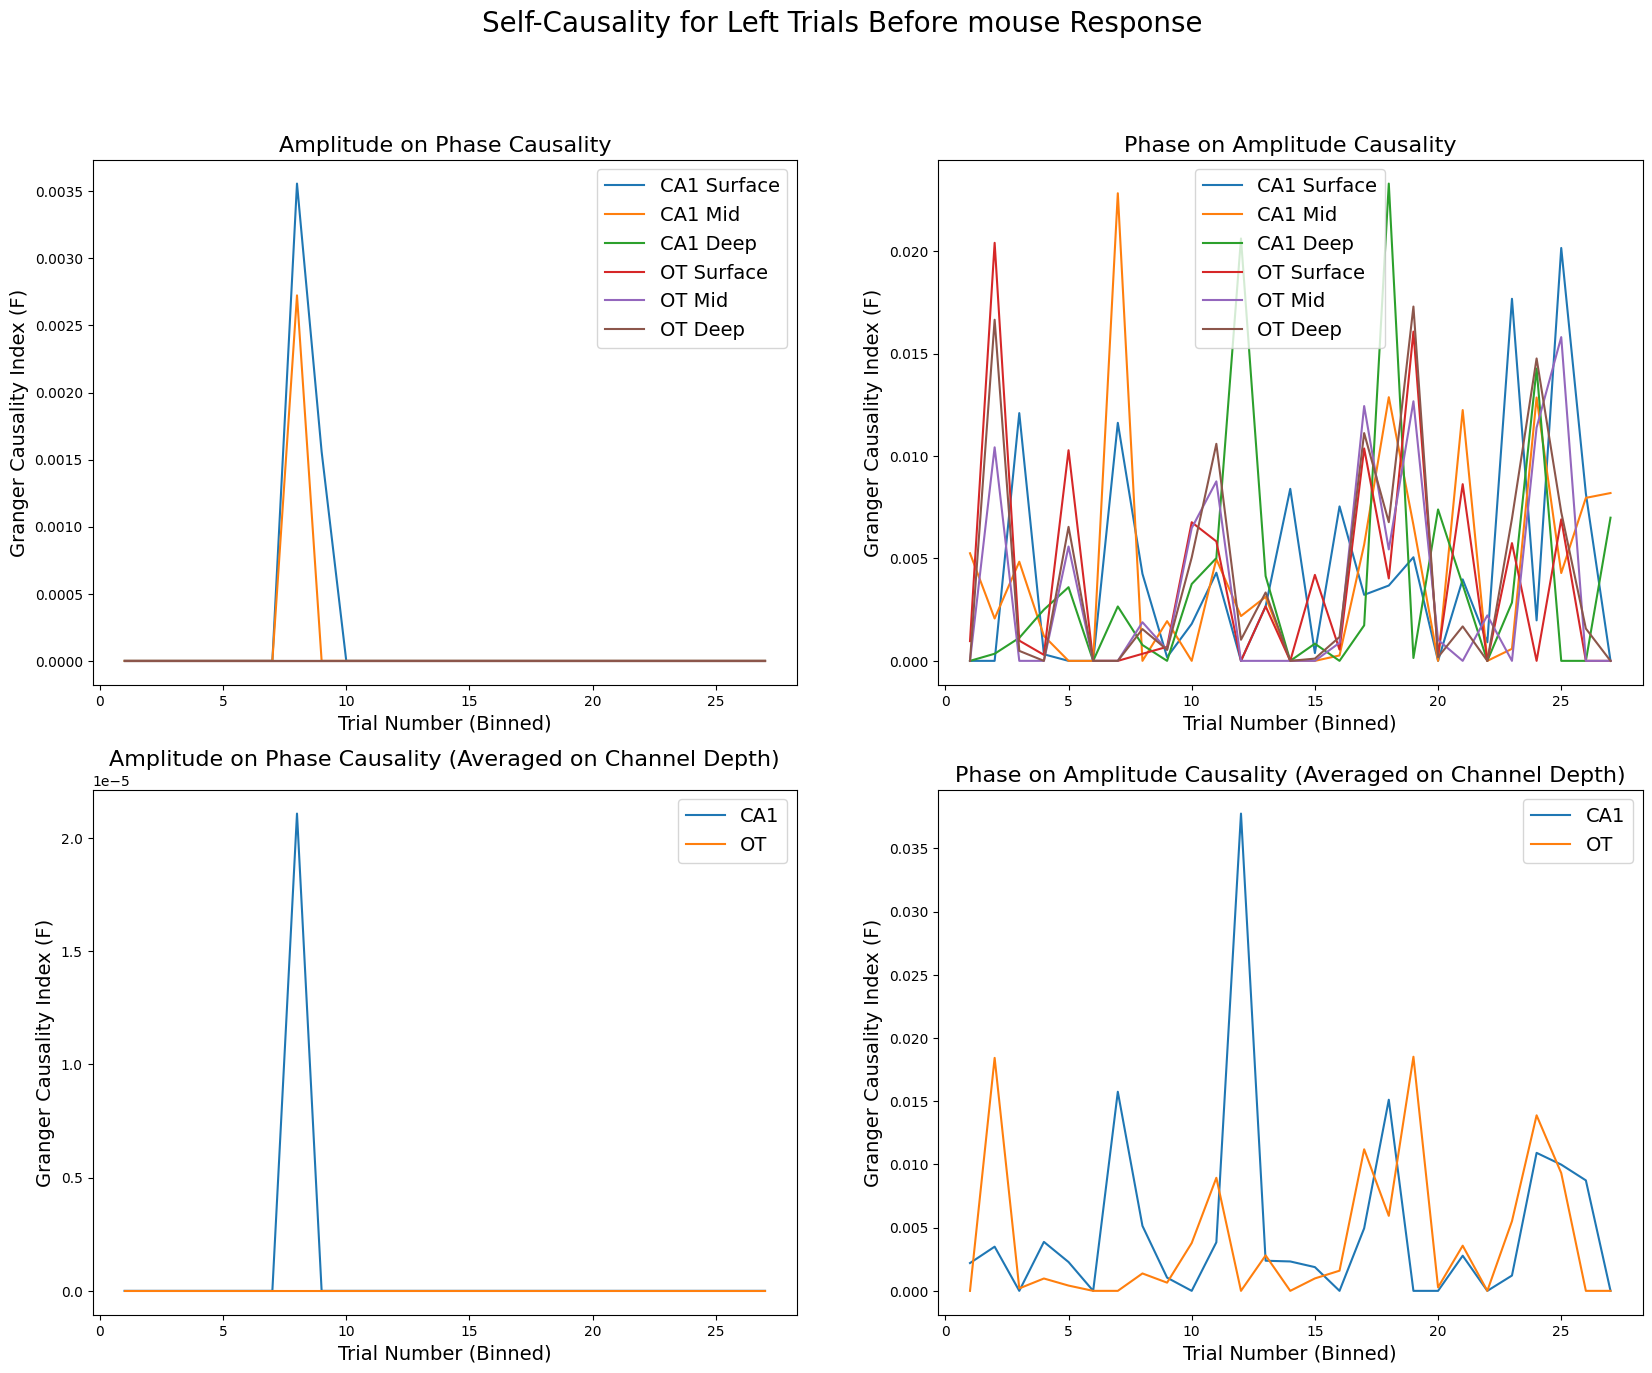

In [57]:
n_trial_bins = ca1_s['left']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Left Trials Before mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_LB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_LB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

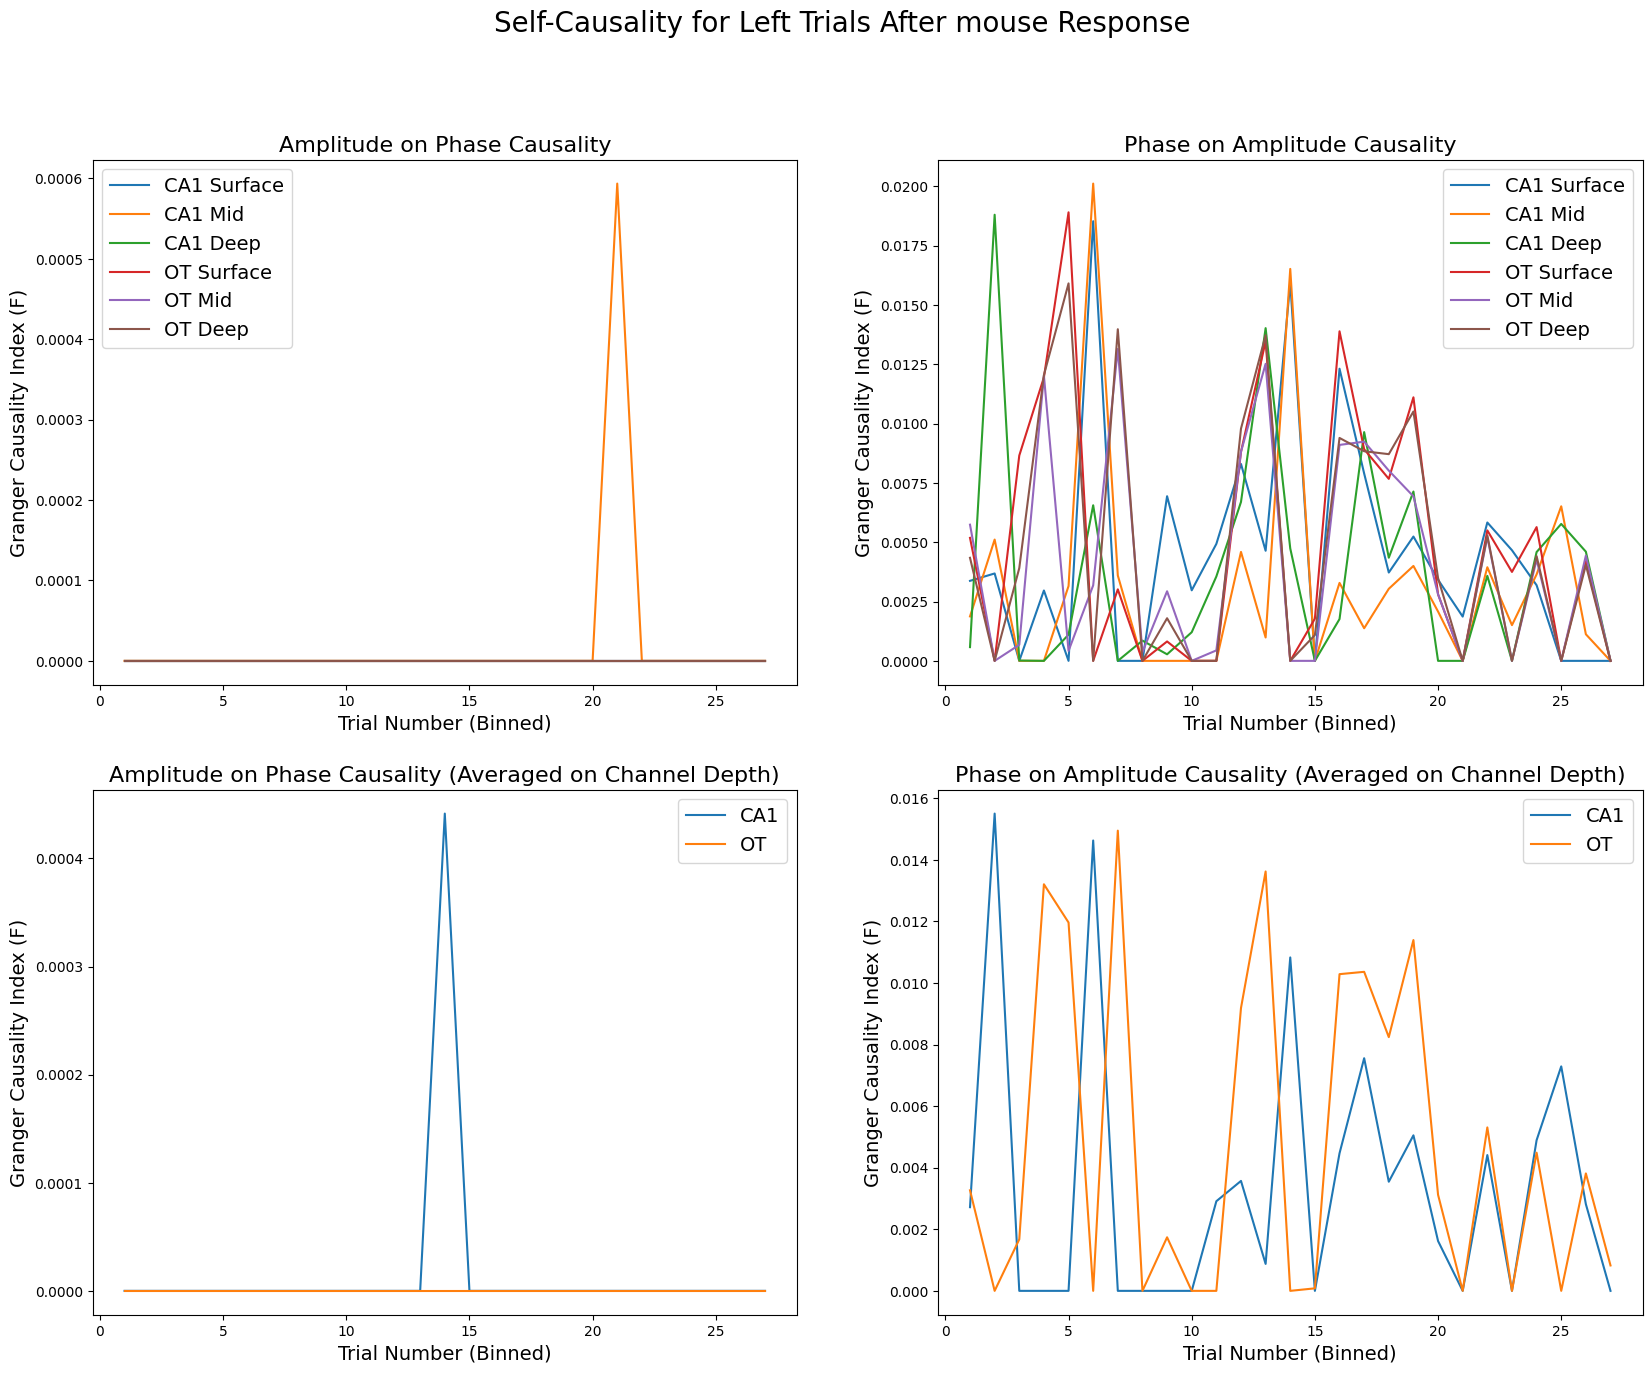

In [58]:
n_trial_bins = ca1_s['left']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Left Trials After mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_LA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_LA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

#### Right Trials

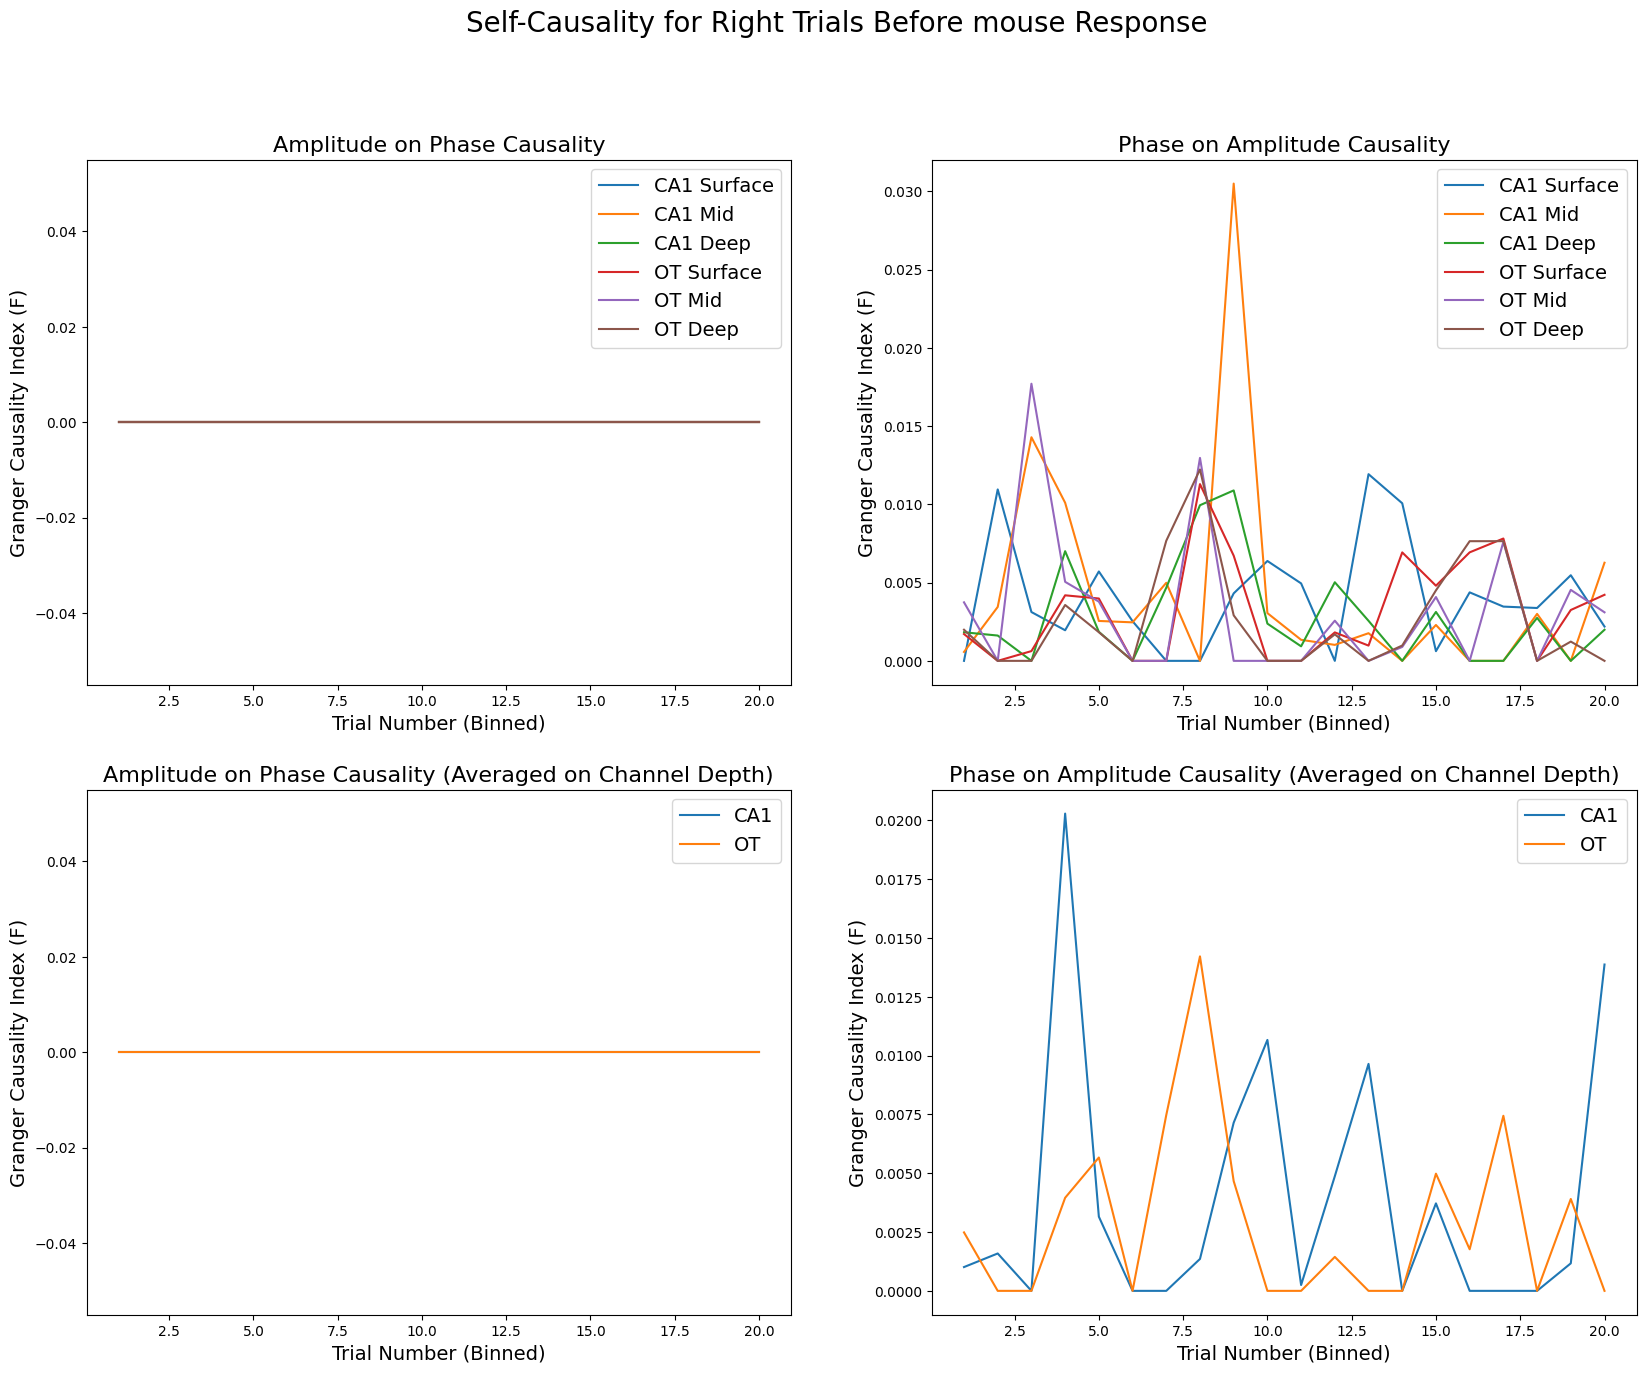

In [59]:
n_trial_bins = ca1_s['right']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Right Trials Before mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_RB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_RB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

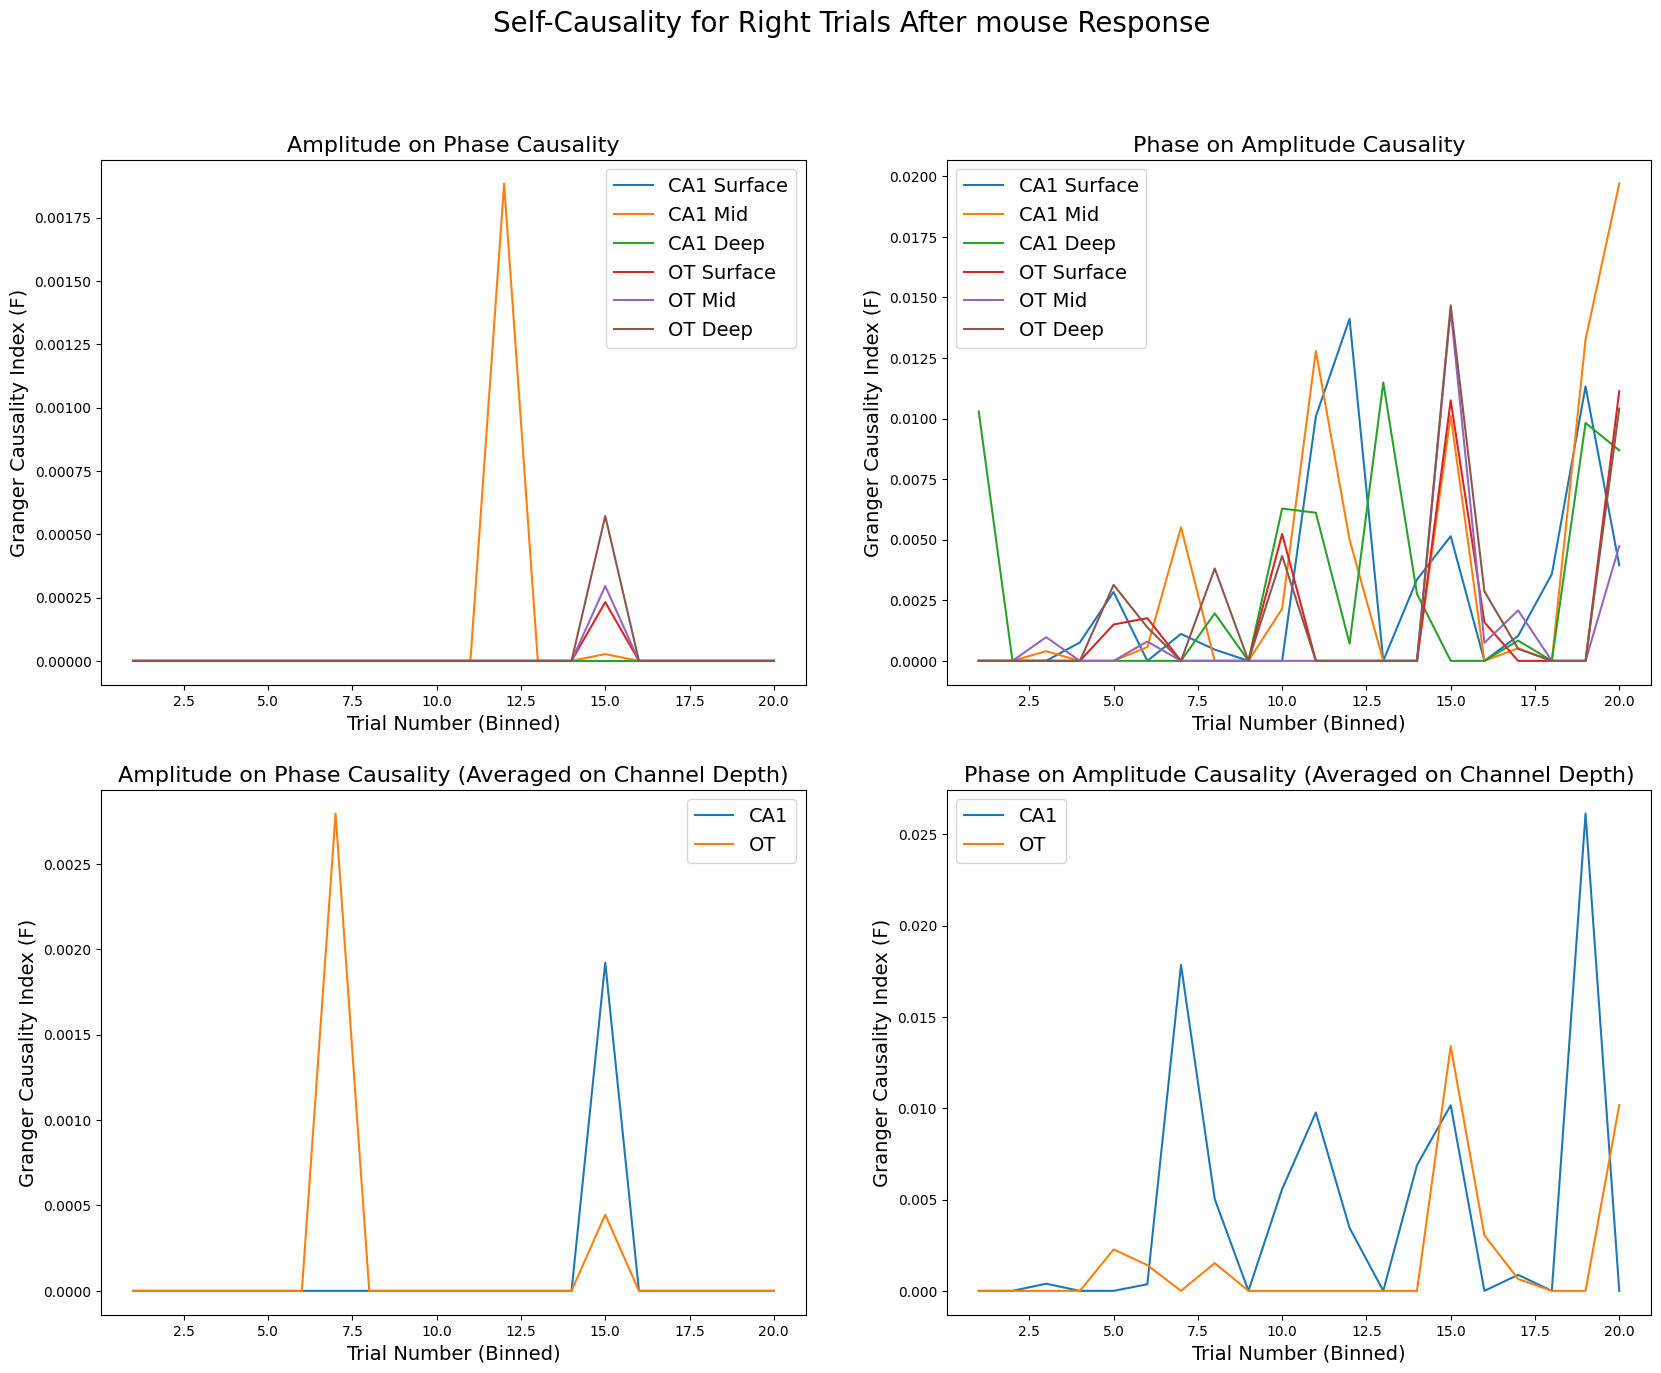

In [60]:
n_trial_bins = ca1_s['right']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Right Trials After mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_RA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_RA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

#### Nogo Trials

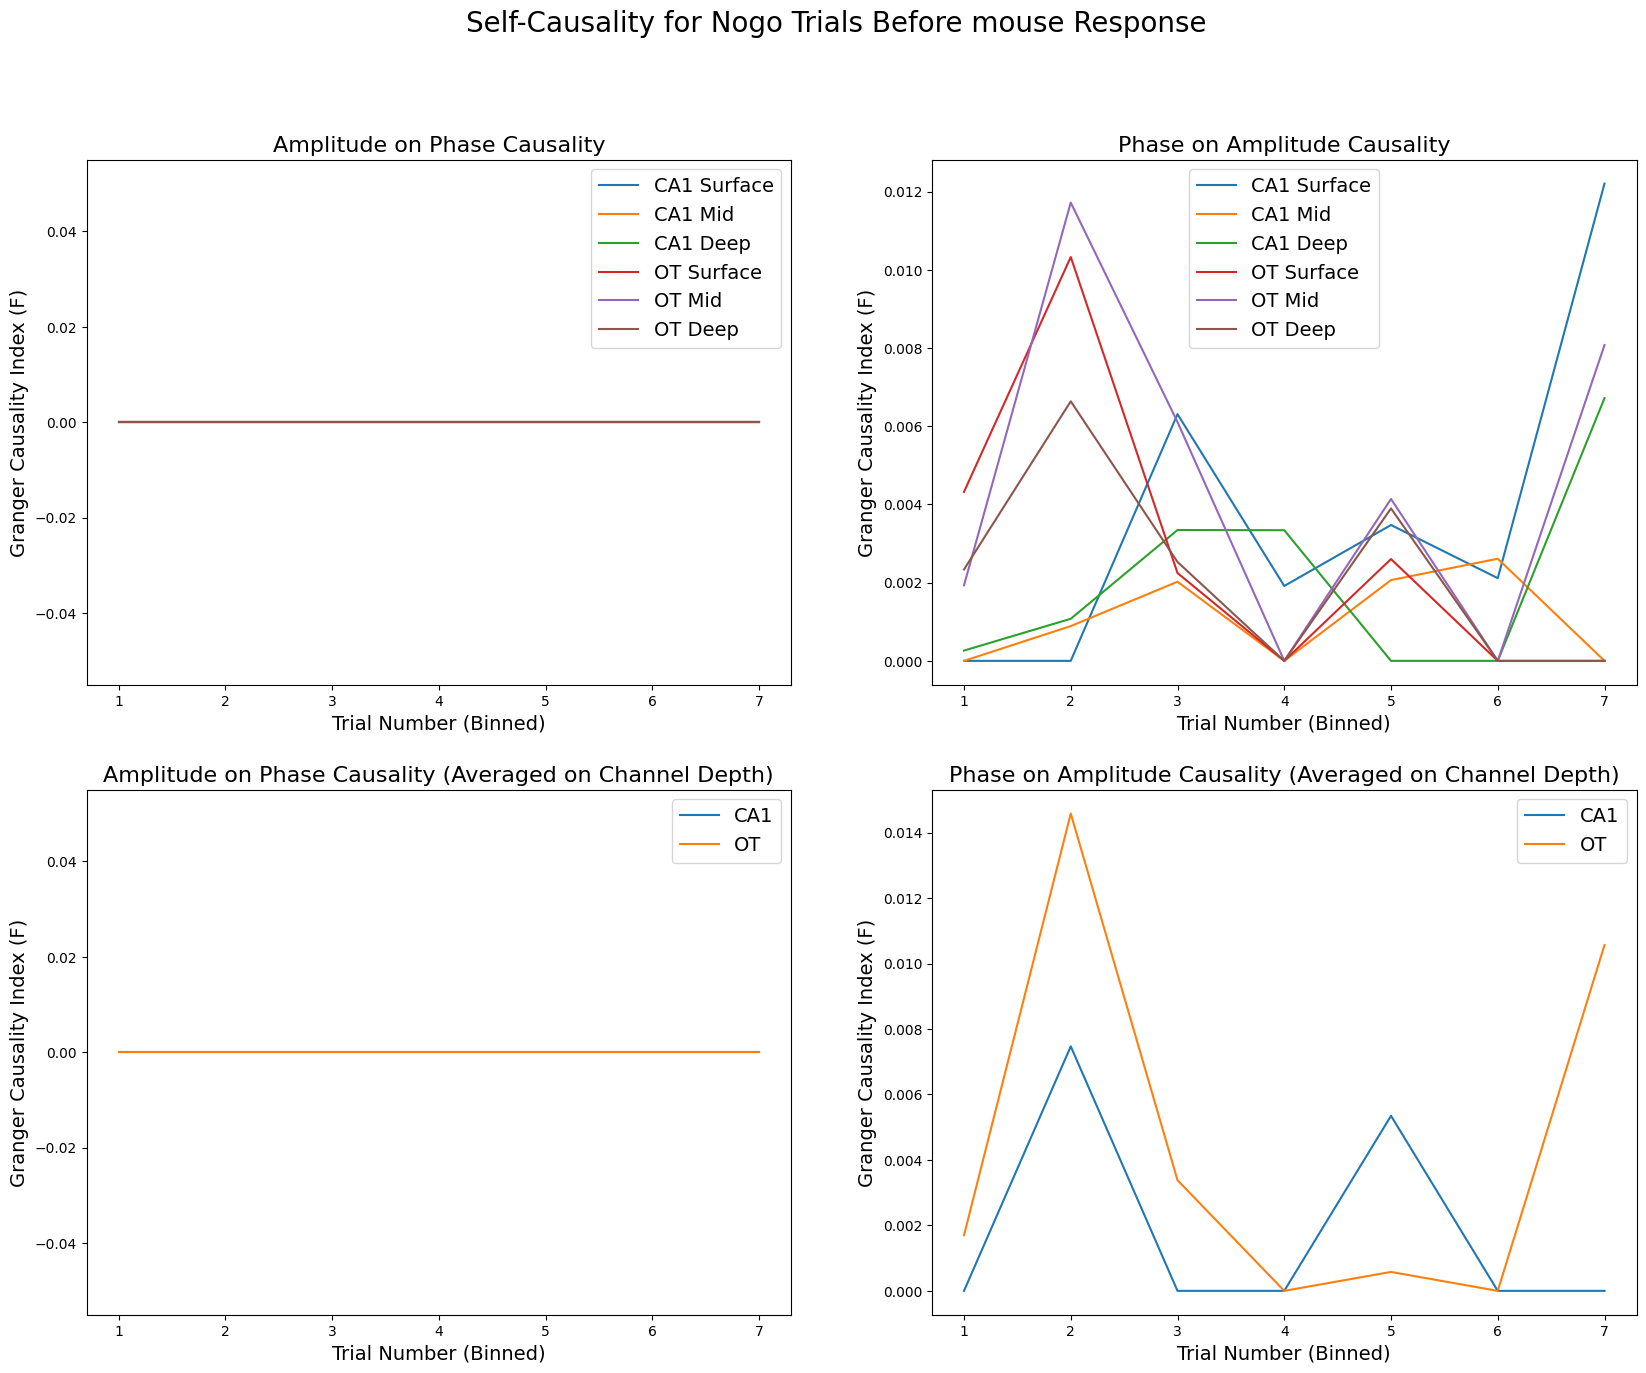

In [61]:
n_trial_bins = ca1_s['nogo']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Nogo Trials Before mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_NB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_NB[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NB[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

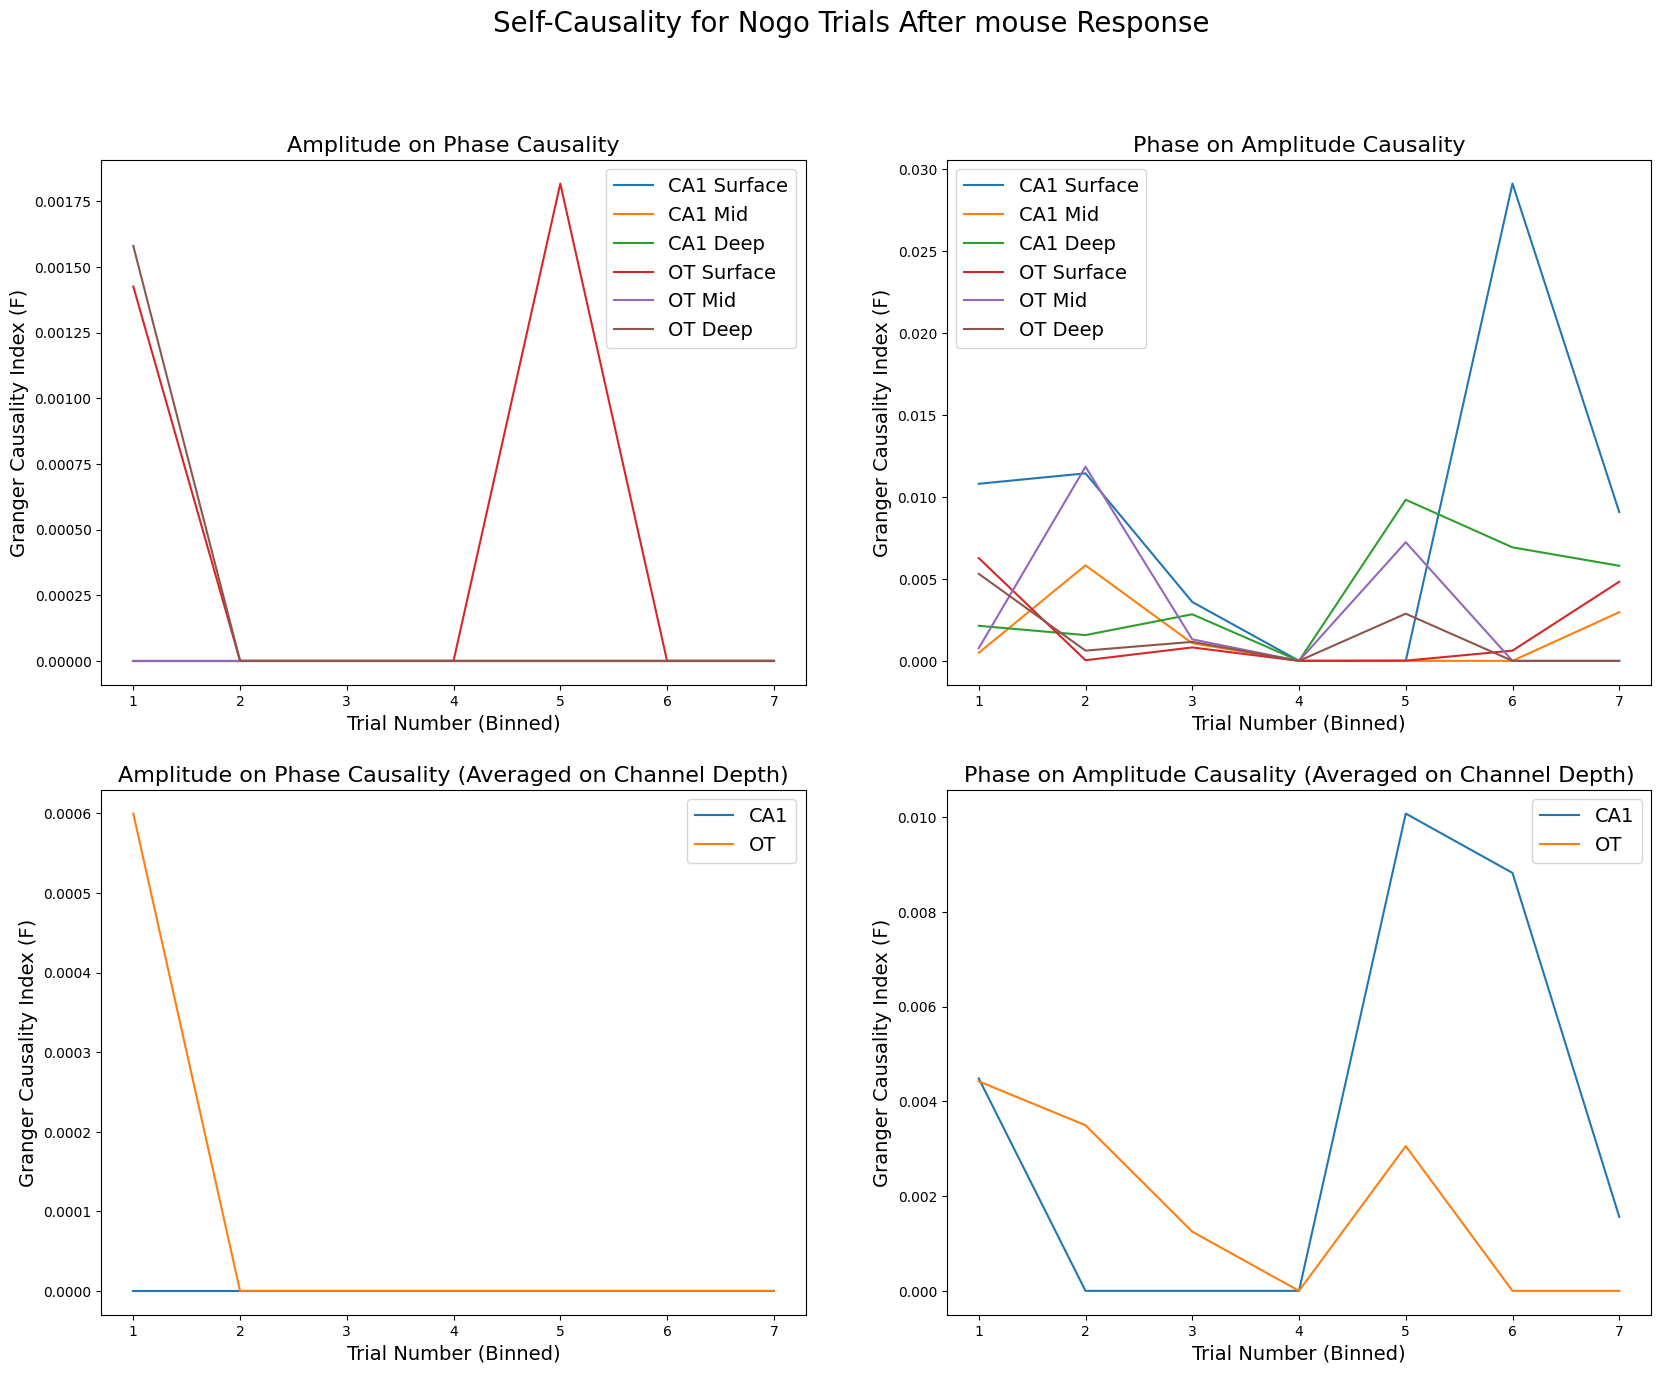

In [62]:
n_trial_bins = ca1_s['nogo']['before'].shape[0]

labels = ['CA1 Surface', 'CA1 Mid', 'CA1 Deep', 'OT Surface', 'OT Mid', 'OT Deep']
labels_mean = ['CA1', 'OT']

f = plt.figure(figsize=(20,15))
f.suptitle('Self-Causality for Nogo Trials After mouse Response', fontsize=20)

plt.subplot(221)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), phase_amp_gc_NA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(222)
for i in range(6):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), amp_phase_gc_NA[:, i, i], label=labels[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality', fontsize=16)
  plt.legend(labels, fontsize=14)

plt.subplot(223)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Amplitude on Phase Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
for i in range(2):
  plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NA[:, i, i], label=labels_mean[i])
  plt.xlabel('Trial Number (Binned)', fontsize=14)
  plt.ylabel('Granger Causality Index (F)', fontsize=14)
  plt.title('Phase on Amplitude Causality (Averaged on Channel Depth)', fontsize=16)
  plt.legend(labels_mean, fontsize=14)

### Cross GC

Generating plots for each channel depth separately will result in **81 distinct pictures**! So we have averaged all channel depths together and calculated Granger Causality using **averaged channel data**

#### Left Trials

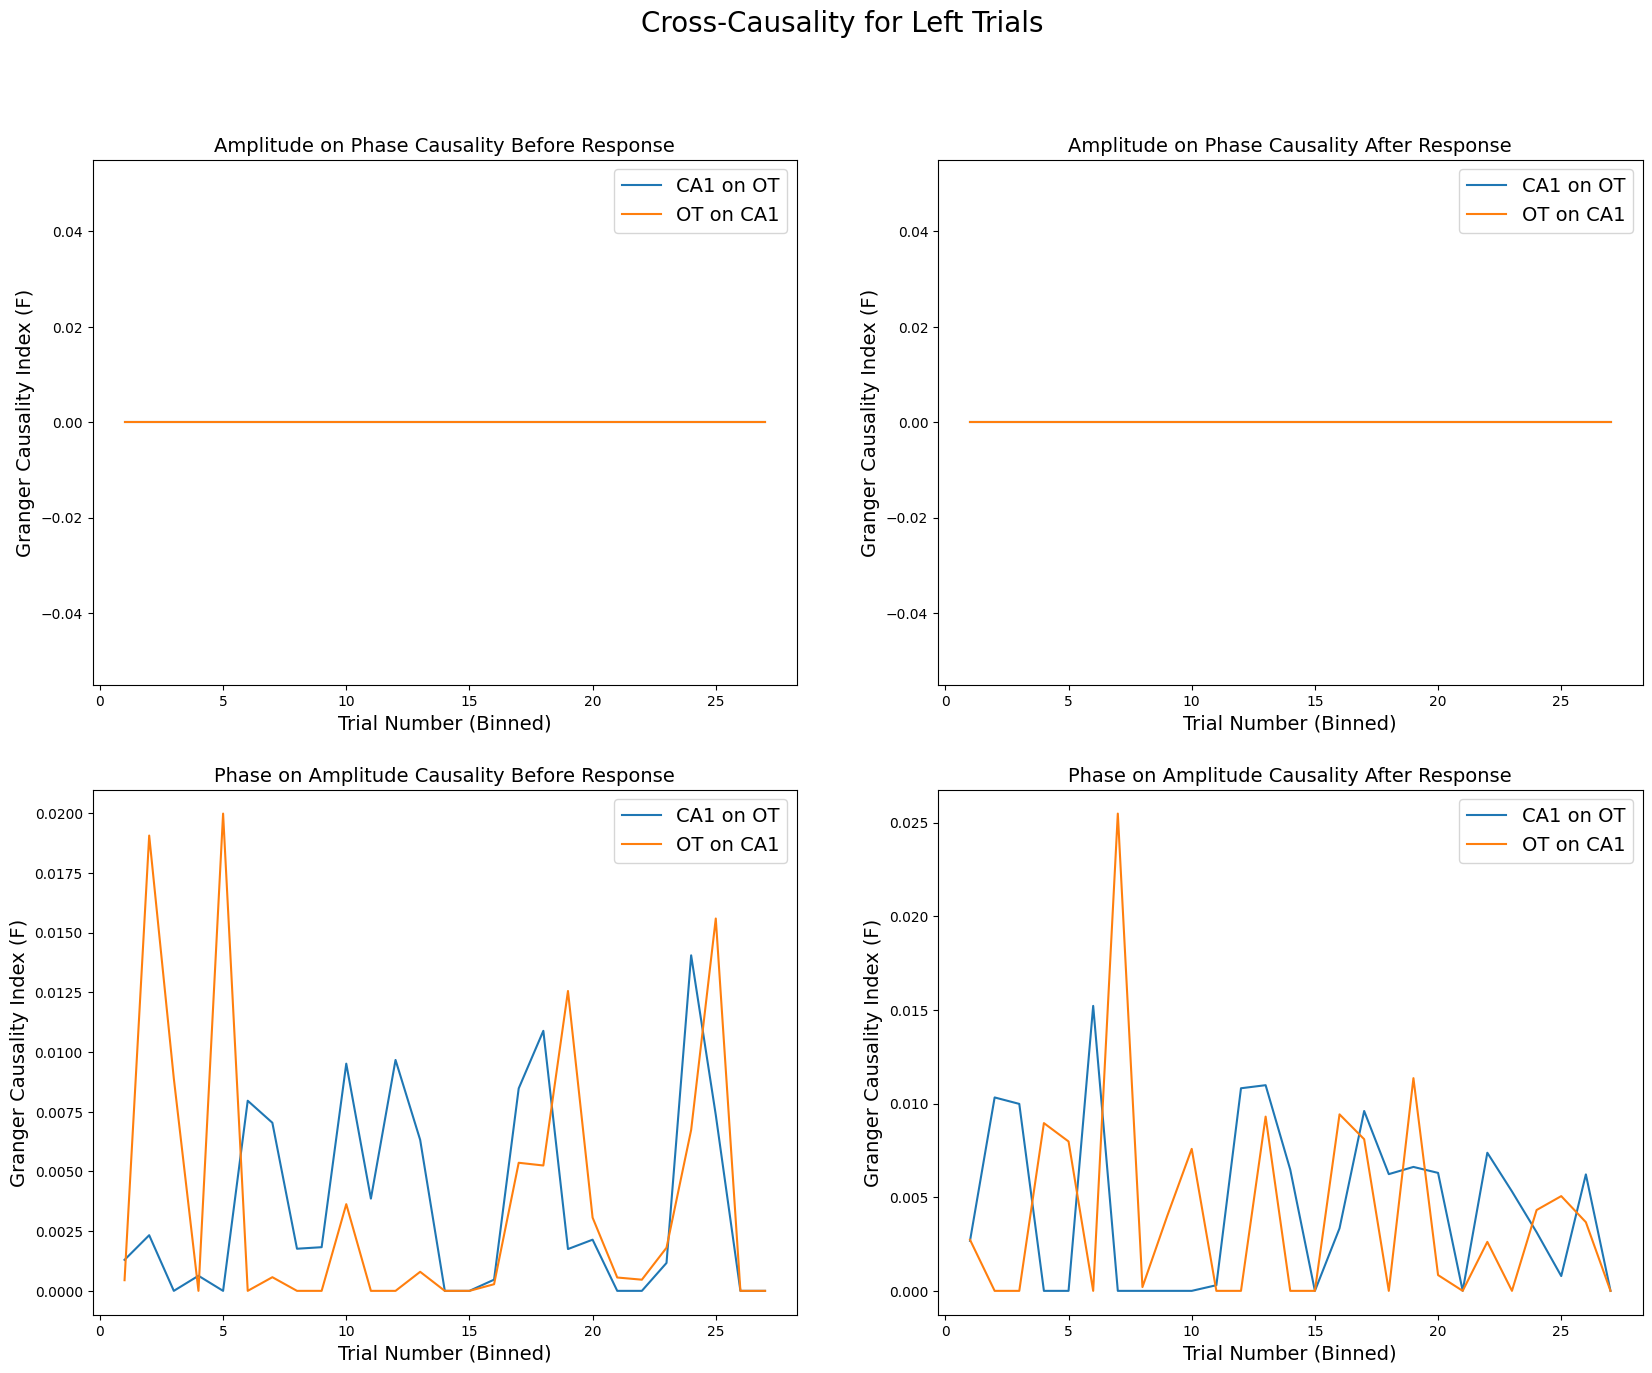

In [64]:
n_trial_bins = ca1_s['left']['before'].shape[0]

labels_mean = ['CA1 on OT', 'OT on CA1']

f = plt.figure(figsize=(20,15))
f.suptitle('Cross-Causality for Left Trials', fontsize=20)

plt.subplot(221)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(222)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_LA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(223)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_LA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

#### Right Trials

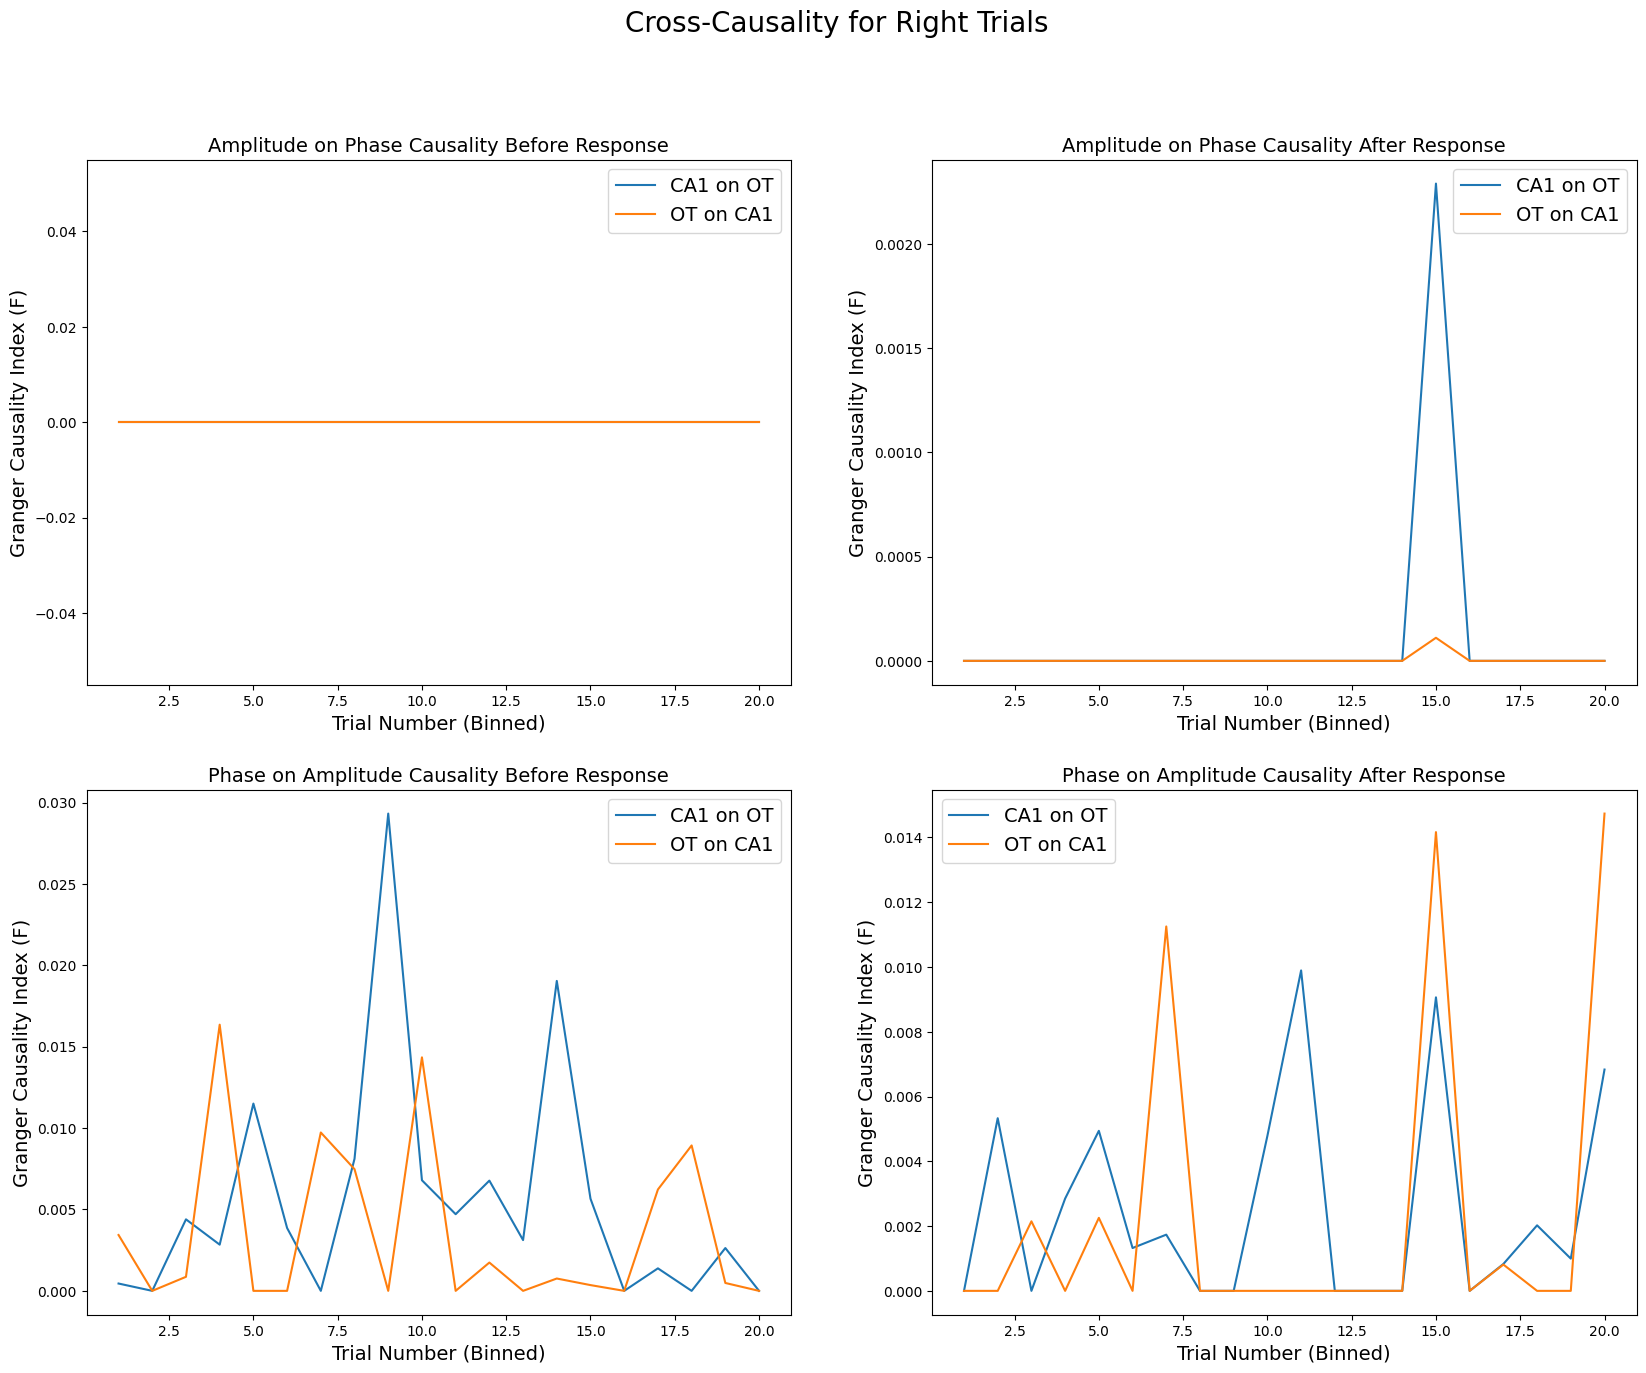

In [65]:
n_trial_bins = ca1_s['right']['before'].shape[0]

labels_mean = ['CA1 on OT', 'OT on CA1']

f = plt.figure(figsize=(20,15))
f.suptitle('Cross-Causality for Right Trials', fontsize=20)

plt.subplot(221)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(222)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_RA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(223)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_RA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

#### Nogo Trials

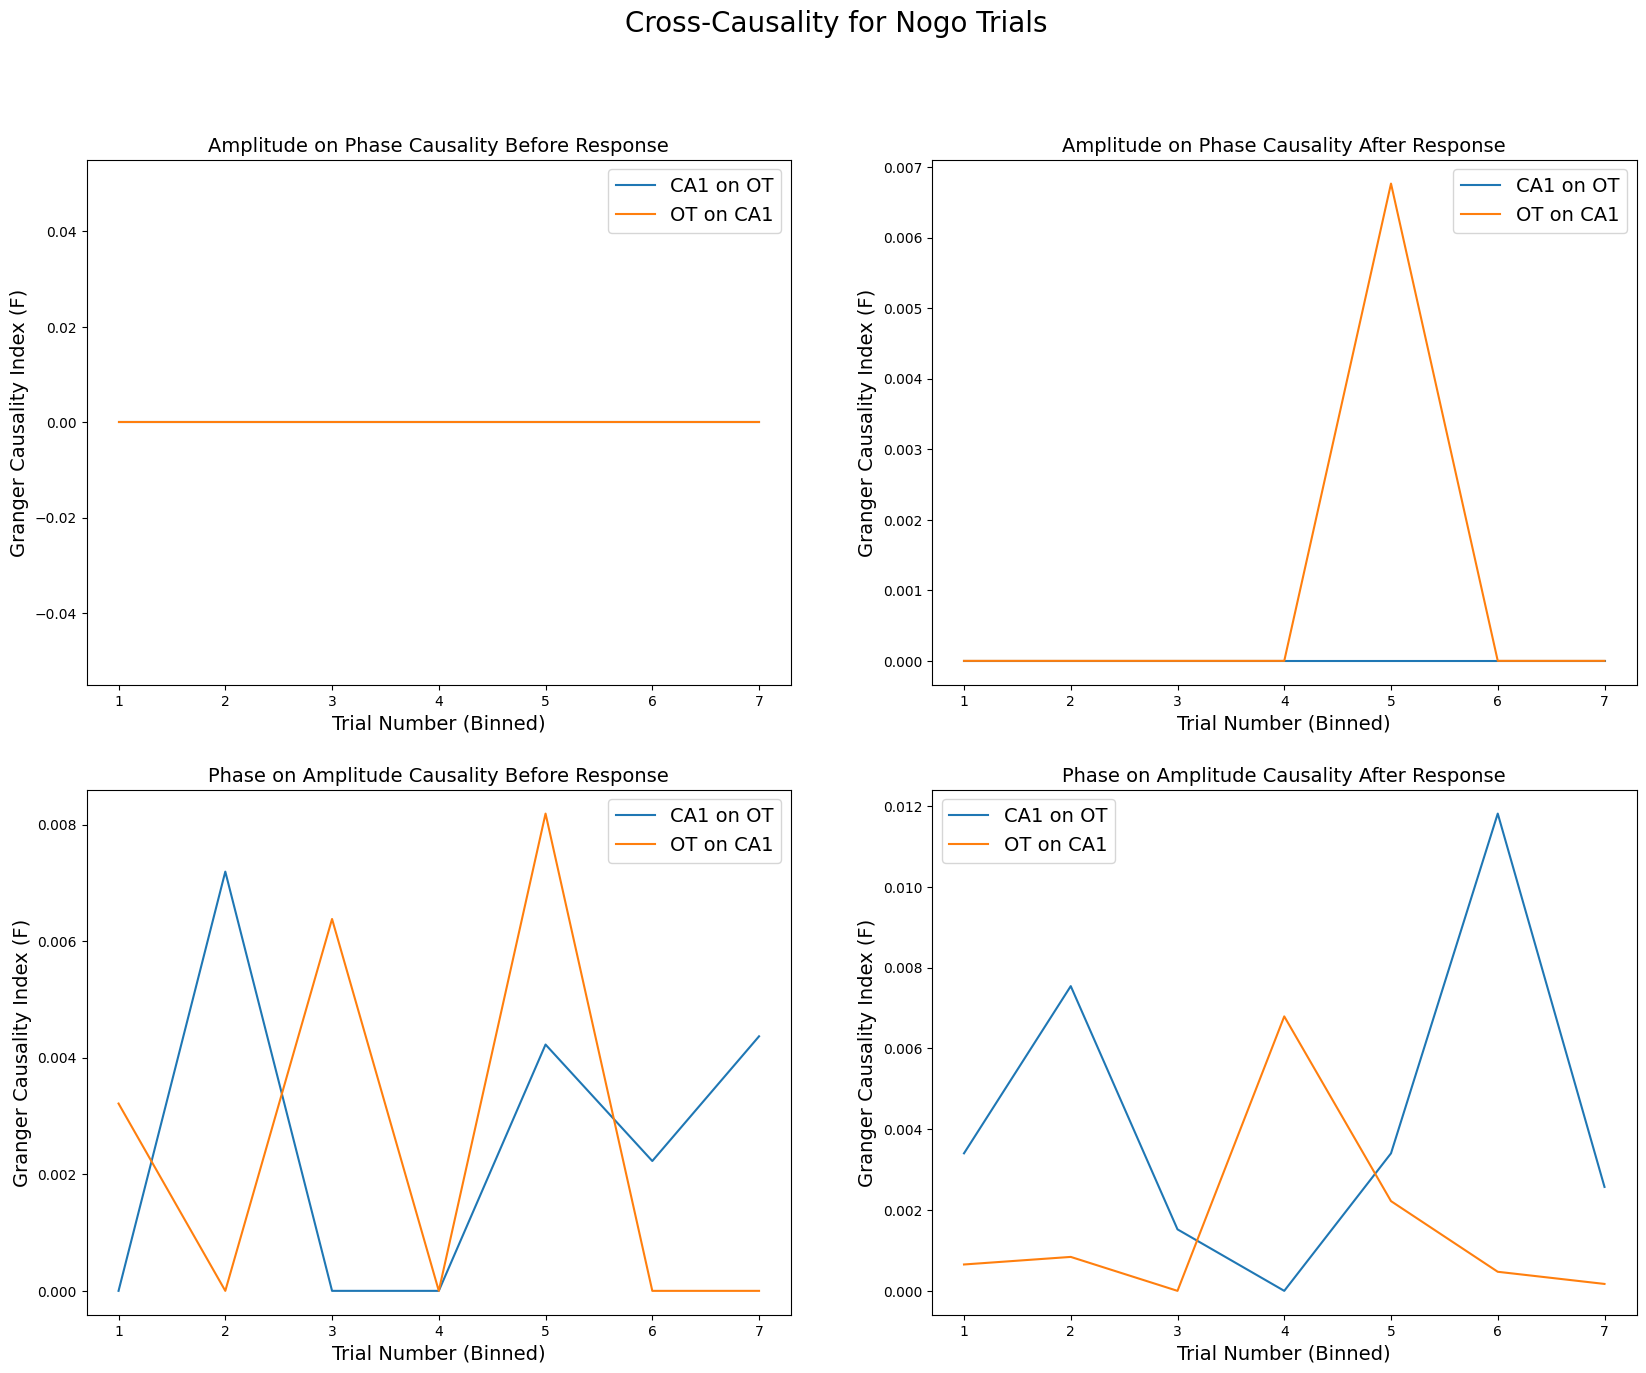

In [66]:
n_trial_bins = ca1_s['nogo']['before'].shape[0]

labels_mean = ['CA1 on OT', 'OT on CA1']

f = plt.figure(figsize=(20,15))
f.suptitle('Cross-Causality for Nogo Trials', fontsize=20)

plt.subplot(221)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(222)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_phase_amp_gc_NA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Amplitude on Phase Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(223)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NB[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NB[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality Before Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

plt.subplot(224)
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NA[:, 0, 1], label=labels_mean[0])
plt.plot(np.arange(start=1, stop=n_trial_bins+1, step=1), mean_amp_phase_gc_NA[:, 1, 0], label=labels_mean[1])
plt.xlabel('Trial Number (Binned)', fontsize=14)
plt.ylabel('Granger Causality Index (F)', fontsize=14)
plt.title('Phase on Amplitude Causality After Response', fontsize=14)
plt.legend(labels_mean, fontsize=14)

## Calculate PAC

In [ ]:
import rid

In [ ]:
# LEFT TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['left']['before'].shape[0]
n_samples = ca1_m['left']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_LB = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['left']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['left']['before'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['left']['before'][i, :], ca1_m['left']['before'][i, :], ca1_d['left']['before'][i, :], \
          ot_s['left']['before'][i, :], ot_m['left']['before'][i, :], ot_d['left']['before'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_LB[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)

In [ ]:
# LEFT TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['left']['after'].shape[0]
n_samples = ca1_m['left']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_LA = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['left']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['left']['after'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['left']['after'][i, :], ca1_m['left']['after'][i, :], ca1_d['left']['after'][i, :], \
          ot_s['left']['after'][i, :], ot_m['left']['after'][i, :], ot_d['left']['after'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_LA[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)

In [ ]:
# RIGHT TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['right']['before'].shape[0]
n_samples = ca1_m['right']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_RB = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['right']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['right']['before'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['right']['before'][i, :], ca1_m['right']['before'][i, :], ca1_d['right']['before'][i, :], \
          ot_s['right']['before'][i, :], ot_m['right']['before'][i, :], ot_d['right']['before'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_RB[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)

In [ ]:
# RIGHT TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['right']['after'].shape[0]
n_samples = ca1_m['right']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_RA = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['right']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['right']['after'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['right']['after'][i, :], ca1_m['right']['after'][i, :], ca1_d['right']['after'][i, :], \
          ot_s['right']['after'][i, :], ot_m['right']['after'][i, :], ot_d['right']['after'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_RA[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)

In [ ]:
# NOGO TRIALS - BEFORE RESPONSE
n_trial_bins = ca1_m['nogo']['before'].shape[0]
n_samples = ca1_m['nogo']['before'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_NB = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['nogo']['before'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['nogo']['before'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['nogo']['before'][i, :], ca1_m['nogo']['before'][i, :], ca1_d['nogo']['before'][i, :], \
          ot_s['nogo']['before'][i, :], ot_m['nogo']['before'][i, :], ot_d['nogo']['before'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_NB[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)

In [ ]:
# NOGO TRIALS - AFTER RESPONSE
n_trial_bins = ca1_m['nogo']['after'].shape[0]
n_samples = ca1_m['nogo']['after'].shape[1]

high_freq = [30, 80]
low_freq = [8,12]

model_order = 10

pac_NA = np.zeros((n_trial_bins, 6, 6))

for i in range(n_trial_bins):
  amp_ca1_s, phase_ca1_s = get_amp_phase(ca1_s['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_m, phase_ca1_m = get_amp_phase(ca1_m['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ca1_d, phase_ca1_d = get_amp_phase(ca1_m['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_s, phase_ot_s = get_amp_phase(ca1_s['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_m, phase_ot_m = get_amp_phase(ca1_m['nogo']['after'][i, :], n_samples, low_freq, high_freq)
  amp_ot_d, phase_ot_d = get_amp_phase(ca1_d['nogo']['after'][i, :], n_samples, low_freq, high_freq)

  sigs = [ca1_s['nogo']['after'][i, :], ca1_m['nogo']['after'][i, :], ca1_d['nogo']['after'][i, :], \
          ot_s['nogo']['after'][i, :], ot_m['nogo']['after'][i, :], ot_d['nogo']['after'][i, :]]

  for j in range(6):
    for k in range(6):
      pac_NA[i, j, k] = rid.tfMVL2(sigs[j], high_freq, sigs[k], low_freq, n_samples)